In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime as dt
import pickle
import numpy as np
import borrador
from __future__ import division
from auxiliar_functions import *
import tfe
from geopy.distance import vincenty
from itertools import chain, combinations


## Funciones Auxiliares

In [9]:
#Función que filtra columnas de acuerdo a una lista de indices
#filter_features: matrix list -> matrix
def filter_features(vector,selected_features):
    selected = []
    for i in range(len(selected_features)):
        selected.append(features_dict[selected_features[i]])
    return vector[:,selected]

In [10]:
#Función que identifica cuantos rois comparten dos grupos de rois y cual es la minima distancia que se descarta como
#rois compartidos
#share_rois: list(dict) list(dict) -> [int,int]
def share_rois(rois_a,rois_b):
    shared = 0
    rois = [rois_a,rois_b]
    index = np.argmin([len(rois_a),len(rois_b)])
    other_index = abs(index-1)
    min_distance = -1
    for i in range(len(rois[index])):
        an_a_roi = rois[index][i]
        lat_a_roi = an_a_roi['lat']
        long_a_roi = an_a_roi['long']
        for j in range(len(rois[other_index])):
            an_b_roi = rois[other_index][j]
            lat_b_roi = an_b_roi['lat']
            long_b_roi = an_b_roi['long']
            a_distance = vincenty((lat_a_roi,long_a_roi),(lat_b_roi,long_b_roi)).meters
            if a_distance < 500:
                shared +=1
            elif min_distance == -1 or min_distance > a_distance:
                min_distance = a_distance
    return [shared,min_distance]

In [11]:
#Función que identifica cuantos rois comparten cada par de rois de dos cortes temporales (ct)
#get_shared_rois: list(list(dict)) list(list(dict)) -> [[int]] list(int)
def get_shared_rois(rois_ct1,rois_ct2,limit):
    init_time = time.time()
    shared = np.ones((limit, limit)) * -1
    min_distance = []
    min_distance_not_shared = -1
    for i in range(limit):
        rois_i = rois_ct1[i]
        for j in range(limit):
            rois_j = rois_ct2[j]
            share_RoIs,min_distance_not_shared = share_rois(rois_i[0],rois_j[0])
            if i==j:
                min_distance.append(min_distance_not_shared)
                min_distance_not_shared = -1
            shared[i,j] = share_RoIs
    delta_time = time.time() - init_time
    print delta_time
    return [shared,min_distance]

In [12]:
def compare_vectors(vector_a,vector_b,rois_a,rois_b,limit,min_shared):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    shared = []
    for i in range(limit):
        rois_abril = rois_a[i]
        for j in range(limit):
            rois_septiembre = rois_b[j]
            min_shared_x = min(len(rois_abril),len(rois_septiembre),min_shared)
            share_RoIs,min_distance_not_shared = share_rois(rois_abril[0],rois_septiembre[0])
            shared.append(share_RoIs)
            if share_RoIs >= min_shared_x:
                a_sequence = vector_a[i]
                b_sequence = vector_b[j]
                dist = np.linalg.norm(np.asarray(a_sequence)-np.asarray(b_sequence))
                a_matrix[i,j] = -dist
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [13]:
def compare_vectors_with_shared_matrix(vector_a,vector_b,rois_a,rois_b,shared_rois,limit,min_shared):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        rois_abril = rois_a[i]
        for j in range(limit):
            rois_septiembre = rois_b[j]
            min_shared_x = min(len(rois_abril),len(rois_septiembre),min_shared)
            share_RoIs = shared_rois[i,j]
            if share_RoIs >= min_shared_x:
                a_sequence = vector_a[i]
                b_sequence = vector_b[j]
                dist = np.linalg.norm(np.asarray(a_sequence)-np.asarray(b_sequence))
                a_matrix[i,j] = -dist
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [14]:
def get_n_correct(a_matrix,limit):
    identified_indexs = [] #almacena los indices de que secuencia fue seleccionada como match
    wrong_indexs = [] # almacena los indices de los que se clasificaron incorrectamente
    correct_indexs = [] # almacena los indices de los que se clasificaron correctamente
    selected_distance = [] # almacena la distancia de los seleccionados
    abstenidos = []
    n_identified = 0
    for i in range(limit):
        the_index = np.argmax(a_matrix[:,i])
        selected_distance.append(a_matrix[the_index,i])
        identified_indexs.append(the_index)
        if a_matrix[the_index,i] == -1:
            abstenidos.append(the_index)
        elif(the_index!=i):
            wrong_indexs.append(the_index)
        else:
            correct_indexs.append(the_index)
            n_identified += 1
    return [n_identified,selected_distance,identified_indexs,abstenidos]


## Obtener datos

In [15]:
with open('data/datos_abril_sep_sequence.pickle') as f:
    datos_abril = pickle.load(f)
    datos_septiembre = pickle.load(f)

In [16]:
with open('data/feature_data.pickle') as f:
    abril_vectors = pickle.load(f)
    septiembre_vectors = pickle.load(f)

In [17]:
limit = np.min((len(abril_vectors),len(septiembre_vectors)))
limit

5169

In [18]:
with open('data/rois_meters_data.pickle') as f:
    abril_the_rois = pickle.load(f)
    septiembre_the_rois = pickle.load(f)

In [21]:
with open('data/shared_rois.pickle') as f:
    shared_rois = pickle.load(f)

In [11]:
with open('data/changed_behaviour.pickle') as f:
    changed_behaviour = pickle.load(f)

EOFError: 

In [ ]:
with open('data/distance_meters_data_2_rois.pickle', 'w') as f:
    pickle.dump(a_matrix, f)

In [44]:
with open('data/freq_correct.pickle', 'w') as f:
    pickle.dump(frequency_correct, f)

## Seleccionar Features para la comparación

In [22]:
N_FEATURES = 19

In [23]:
features_names = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

In [24]:
features_dict = {"msal":0,"mlal":1,"kmDistance":2,"kmMaxDist":3,"kmMinDist":4,"rg":5,"unc_entropy":6,
                  "random_entropy":7,"p100_diff_last_origin":8,"p100_diff_first_origin":9,"card_type":10,
                  "start_time":11,"end_time":12,"traveled_days":13,"traveled_days_bs":14,"frequence_regularity":15,
                  "p100_exclusive_bus_days":16,"p100_exclusive_metro_days":17,"P100_bus_trips":18}

In [47]:
selected_features = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin",\
    "start_time","end_time","traveled_days","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

#selected_features = ['msal', 'mlal', 'kmDistance', 'unc_entropy', 'random_entropy', 'start_time']

In [57]:
selected_features= ['msal',
 'kmMaxDist',
 'unc_entropy',
 'random_entropy',
 'start_time',
 'frequence_regularity',
 'p100_exclusive_bus_days',
 'P100_bus_trips']

In [58]:
abril_selected_features = filter_features(abril_vectors,selected_features)
septiembre_selected_features = filter_features(septiembre_vectors,selected_features)

In [59]:
abril_selected_features.shape

(5169, 8)

## Obtener Numero de Rois Compartidos

In [54]:
shared_rois,min_distance = get_shared_rois(abril_the_rois,septiembre_the_rois,limit)

5815.20309901


In [62]:
min(min_distance)

-1

In [63]:
a_min_distance = filter(lambda x:x!=-1,min_distance)

In [66]:
len(a_min_distance)

5120

In [69]:
min(a_min_distance)

500.1444526200718

(array([ 255.,  218.,  229.,  183.,  126.,  117.,   94.,   99.,   99.,
          79.,   77.,   84.,   88.,   76.,   73.,   53.,   51.,   50.,
          69.,   62.,   51.,   46.,   52.,   44.,   37.,   30.,   43.,
          29.,   45.,   32.,   37.,   44.,   42.,   31.,   33.,   32.,
          30.,   26.,   32.,   31.,   22.,   37.,   32.,   23.,   13.,
          31.,   33.,   23.,   25.,   22.,   30.,   26.,   23.,   31.,
          27.,   15.,   21.,   17.,   22.,   25.,   26.,   21.,   22.,
          26.,   24.,   15.,   24.,   16.,   24.,   21.,   16.,   30.,
          25.,   23.,   19.,   20.,   21.,   18.,   17.,   22.,   25.,
          18.,   18.,   14.,   20.,   17.,    7.,    9.,   15.,   17.,
          17.,   27.,   24.,   20.,    9.,   19.,   14.,   23.,    9.,
          16.,   15.,   12.,   17.,   10.,   18.,   13.,   18.,   17.,
          14.,   14.,   22.,   11.,   20.,   10.,   15.,   12.,   10.,
          12.,   11.,    8.,   13.,   16.,   15.,   13.,    8.,    9.,
      

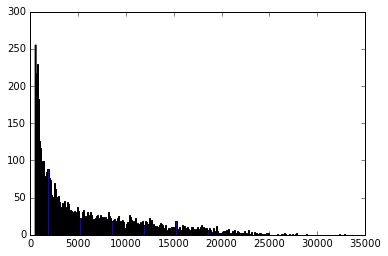

In [72]:
plt.hist(a_min_distance,300)

## Comparar con distintos numeros de rois

### Solo un RoI compartido

In [81]:
a_matrix = compare_vectors_with_shared_matrix(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,1)

28.6182448864


In [82]:
n_identified,selected_distance,identified_indexs = get_n_correct(a_matrix,limit)

In [83]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

20.47%


In [84]:
shared_rois_2_month = 0
for i in range(limit):
    if a_matrix[i,i] != -1:
        shared_rois_2_month += 1
print str(round(shared_rois_2_month*100/limit,2)) + "%"

93.38%


### Dos RoI compartidos

In [60]:
a_matrix = compare_vectors_with_shared_matrix(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2)

18.1008679867


In [61]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix,limit)

In [62]:
len(identified_indexs)

5169

In [63]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

44.42%


In [46]:
shared_rois_2_month = 0
for i in range(limit):
    if a_matrix[i,i] != -1:
        shared_rois_2_month += 1
print str(round(shared_rois_2_month*100/limit,2)) + "%"

54.85%


In [125]:
len(abstenidos)

1349

In [126]:
1349/limit*100

26.097891274908108

In [72]:
def counterx(a):
    b = filter(lambda x: x!=-1,a)
    return len(b)

In [73]:
counterx([1,2,3,4,-1,-1,5,-1])

5

In [ ]:
shared_rois_2_month = 0
for i in range(limit):
    if a_matrix[i,i] != -1:
        if identified_index == i:
print str(round(shared_rois_2_month*100/limit,2)) + "%"

### Tres RoIs compartidos

In [127]:
a_matrix = compare_vectors_with_shared_matrix(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,3)

17.5351469517


In [128]:
n_identified,selected_distance,identified_indexs = get_n_correct(a_matrix,limit)

ValueError: too many values to unpack

In [ ]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

In [ ]:
shared_rois_2_month = 0
for i in range(limit):
    if a_matrix[i,i] != -1:
        shared_rois_2_month += 1
print str(round(shared_rois_2_month*100/limit,2)) + "%"

### Cuatro RoIs compartidos

In [85]:
a_matrix = compare_vectors_with_shared_matrix(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,4)

17.5743842125


In [86]:
n_identified,selected_distance,identified_indexs = get_n_correct(a_matrix,limit)

In [87]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

44.55%


In [88]:
shared_rois_2_month = 0
for i in range(limit):
    if a_matrix[i,i] != -1:
        shared_rois_2_month += 1
print str(round(shared_rois_2_month*100/limit,2)) + "%"

54.85%


### Análisis de resultados con 2 rois

In [ ]:
x = np.array(identified_indexs_2)
y = np.bincount(x)
ii = np.nonzero(y)[0]

In [ ]:
frequency_correct = zip(ii,y[ii]) 
counter = 0
ncounter = 0
freq_max_1 = 0
freq_max_2 = 0
freq_max_3 = 0
for element in frequency_correct:
    if(element[1]>1):
        counter +=1
        ncounter += element[1]

In [ ]:
frequency_correct.sort(key = lambda t: t[1], reverse=True)
frequency_correct

### Medir distancia de los descriptores del para casos de match

In [65]:
min_distance_features_correct = []
std_distance_features_correct = []
max_distance_features_correct = []
mean_distance_features_correct = []
euclidean_distance_matrix = abs(abril_vectors-septiembre_vectors)
#obtengo para cada feature las estadisticas de los identificados correctamente
for j in range(N_FEATURES):
    min_distance_features_correct.append(min(euclidean_distance_matrix[:,j]))
    std_distance_features_correct.append(np.std(euclidean_distance_matrix[:,j]))
    max_distance_features_correct.append(max(euclidean_distance_matrix[:,j]))
    mean_distance_features_correct.append(np.mean(euclidean_distance_matrix[:,j]))

### Medir distancia de los descriptores en comparación a todos

In [ ]:
min_distance_features = []
std_distance_features = []
max_distance_features = []
mean_distance_features = []
distance_feature_matrix = np.zeros((limit, N_FEATURES))
#obtengo para cada feature las distancias de cada feature en general
for j in range(N_FEATURES):
    #resto el valor de la feature j,i a septiembre j guardo la distancia
    for i in range(limit):
        the_dist = np.mean(abs(septiembre_vectors[:,j]-abril_vectors[i,j]))
        distance_feature_matrix[i,j] = the_dist
    min_distance_features.append(min(distance_feature_matrix[:,j]))
    std_distance_features.append(np.std(distance_feature_matrix[:,j]))
    max_distance_features.append(max(distance_feature_matrix[:,j]))
    mean_distance_features.append(np.mean(distance_feature_matrix[:,j]))

### Medir distancia de los descriptores para casos de vecinos

In [16]:
min_distance_features_neighbour = []
std_distance_features_neighbour = []
max_distance_features_neighbour = []
mean_distance_features_neighbour = []
distance_feature_matrix = np.zeros((limit, N_FEATURES))

for i in range(limit):
    neighbours_i = get_neighbours(i,shared_rois)
    if len(neighbours_i) > 0:
        #todo:debiese ser arreglo de ceros 
        sum_dist = range(N_FEATURES)
        #todo:debiese no se si esto funcione
        for n in neighbours_i:
            sum_dist += abs(septiembre_vectors[n,:]-abril_vectors[i,:])
        distance_feature_matrix[i,:] = sum_dist/len(neighbours_i)
    else:
        #todo: valor nan? si no tiene vecinitos
        
    min_distance_features_neighbour.append(min(distance_feature_matrix[:,j]))
    std_distance_features_neighbour.append(np.std(distance_feature_matrix[:,j]))
    max_distance_features_neighbour.append(max(distance_feature_matrix[:,j]))
    mean_distance_features_neighbour.append(np.mean(distance_feature_matrix[:,j]))
    

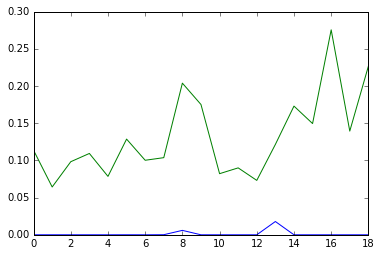

In [17]:
plt.figure()
plt.plot(min_distance_features_correct)
plt.hold(True)
plt.plot(min_distance_features)

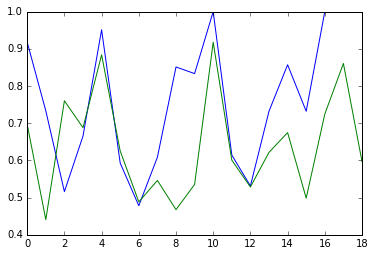

In [18]:
plt.figure()
plt.plot(max_distance_features_correct)
plt.hold(True)
plt.plot(max_distance_features)

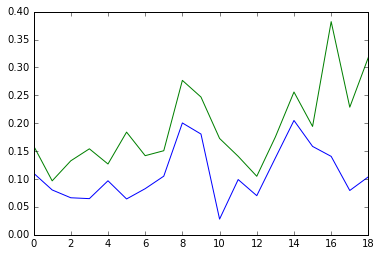

In [19]:
plt.figure()
plt.plot(mean_distance_features_correct)
plt.hold(True)
plt.plot(mean_distance_features)

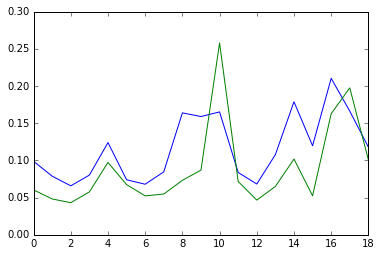

In [20]:
plt.figure()
plt.plot(std_distance_features_correct)
plt.hold(True)
plt.plot(std_distance_features)

### Histogramas de distancia por características

(array([  2.73300000e+03,   1.45700000e+03,   6.21000000e+02,
          2.25000000e+02,   9.10000000e+01,   3.00000000e+01,
          6.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.09177064,  0.18354127,  0.27531191,  0.36708254,
         0.45885318,  0.55062382,  0.64239445,  0.73416509,  0.82593573,
         0.91770636]),
 <a list of 10 Patch objects>)

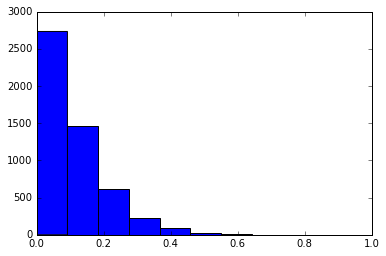

In [27]:
plt.hist(euclidean_distance_matrix[:,0])

(array([  3.06900000e+03,   1.25000000e+03,   5.20000000e+02,
          2.03000000e+02,   7.30000000e+01,   3.80000000e+01,
          1.30000000e+01,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  1.21461306e-05,   7.33373035e-02,   1.46662461e-01,
          2.19987618e-01,   2.93312776e-01,   3.66637933e-01,
          4.39963090e-01,   5.13288248e-01,   5.86613405e-01,
          6.59938562e-01,   7.33263720e-01]),
 <a list of 10 Patch objects>)

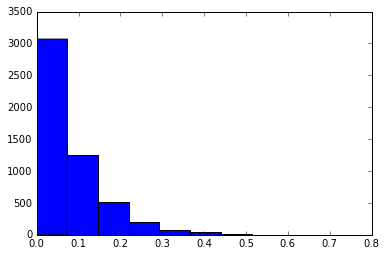

In [28]:
plt.hist(euclidean_distance_matrix[:,1])

(array([ 2800.,  1332.,   561.,   248.,   115.,    57.,    27.,    15.,
           11.,     3.]),
 array([  5.54491703e-06,   5.16028167e-02,   1.03200089e-01,
          1.54797360e-01,   2.06394632e-01,   2.57991904e-01,
          3.09589176e-01,   3.61186448e-01,   4.12783720e-01,
          4.64380991e-01,   5.15978263e-01]),
 <a list of 10 Patch objects>)

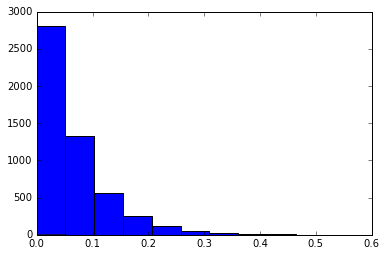

In [29]:
plt.hist(euclidean_distance_matrix[:,2])

(array([  3.51900000e+03,   8.66000000e+02,   3.91000000e+02,
          2.22000000e+02,   9.20000000e+01,   4.80000000e+01,
          2.10000000e+01,   5.00000000e+00,   3.00000000e+00,
          2.00000000e+00]),
 array([  1.56590030e-05,   6.65598795e-02,   1.33104100e-01,
          1.99648320e-01,   2.66192541e-01,   3.32736761e-01,
          3.99280982e-01,   4.65825202e-01,   5.32369423e-01,
          5.98913643e-01,   6.65457864e-01]),
 <a list of 10 Patch objects>)

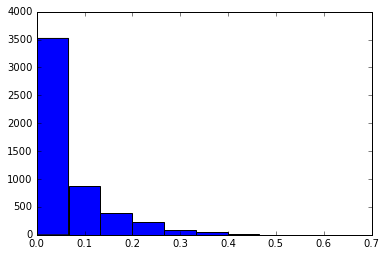

In [30]:
plt.hist(euclidean_distance_matrix[:,3])

(array([ 3535.,   828.,   372.,   204.,   113.,    62.,    33.,    12.,
            6.,     4.]),
 array([  1.38349847e-06,   9.51155772e-02,   1.90229771e-01,
          2.85343965e-01,   3.80458158e-01,   4.75572352e-01,
          5.70686546e-01,   6.65800739e-01,   7.60914933e-01,
          8.56029127e-01,   9.51143321e-01]),
 <a list of 10 Patch objects>)

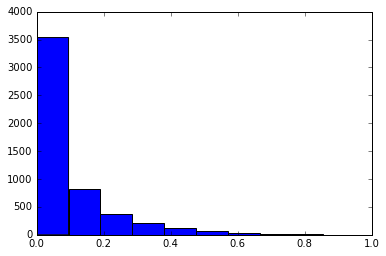

In [31]:
plt.hist(euclidean_distance_matrix[:,4])

(array([ 3372.,  1003.,   407.,   177.,    97.,    51.,    37.,    17.,
            4.,     4.]),
 array([  2.84309008e-05,   5.93086692e-02,   1.18588907e-01,
          1.77869146e-01,   2.37149384e-01,   2.96429622e-01,
          3.55709861e-01,   4.14990099e-01,   4.74270337e-01,
          5.33550576e-01,   5.92830814e-01]),
 <a list of 10 Patch objects>)

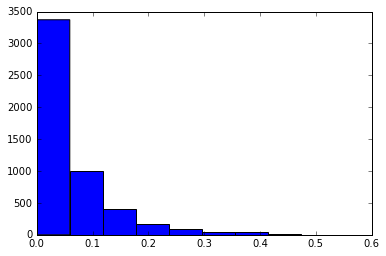

In [32]:
plt.hist(euclidean_distance_matrix[:,5])

(array([ 1966.,  1447.,   901.,   448.,   234.,   109.,    34.,    22.,
            4.,     4.]),
 array([  1.08771523e-06,   4.78113294e-02,   9.56215711e-02,
          1.43431813e-01,   1.91242055e-01,   2.39052296e-01,
          2.86862538e-01,   3.34672780e-01,   3.82483021e-01,
          4.30293263e-01,   4.78103505e-01]),
 <a list of 10 Patch objects>)

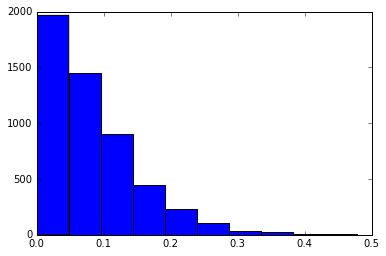

In [33]:
plt.hist(euclidean_distance_matrix[:,6])

(array([ 1801.,  1576.,   834.,   552.,   255.,    95.,    40.,    12.,
            2.,     2.]),
 array([  1.09912402e-04,   6.09483957e-02,   1.21786879e-01,
          1.82625362e-01,   2.43463846e-01,   3.04302329e-01,
          3.65140812e-01,   4.25979296e-01,   4.86817779e-01,
          5.47656262e-01,   6.08494746e-01]),
 <a list of 10 Patch objects>)

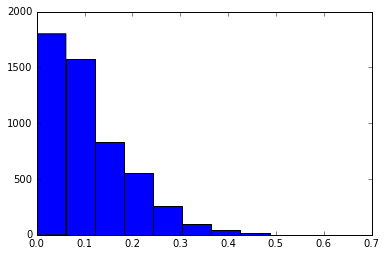

In [34]:
plt.hist(euclidean_distance_matrix[:,7])

(array([ 1680.,   827.,  1138.,   529.,   504.,   181.,   171.,    82.,
           30.,    27.]),
 array([ 0.00595238,  0.09047619,  0.175     ,  0.25952381,  0.34404762,
         0.42857143,  0.51309524,  0.59761905,  0.68214286,  0.76666667,
         0.85119048]),
 <a list of 10 Patch objects>)

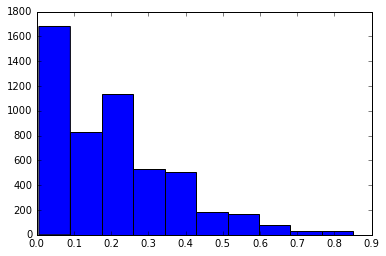

In [36]:
plt.hist(euclidean_distance_matrix[:,8])

(array([ 1615.,  1129.,   996.,   563.,   411.,   159.,   150.,    74.,
           43.,    29.]),
 array([ 0.        ,  0.08333333,  0.16666667,  0.25      ,  0.33333333,
         0.41666667,  0.5       ,  0.58333333,  0.66666667,  0.75      ,
         0.83333333]),
 <a list of 10 Patch objects>)

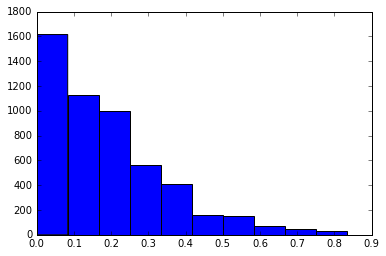

In [37]:
plt.hist(euclidean_distance_matrix[:,9])

(array([  5.02300000e+03,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.45000000e+02]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

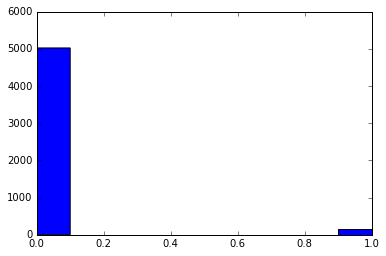

In [38]:
plt.hist(euclidean_distance_matrix[:,10])

(array([ 2189.,  1558.,   732.,   361.,   149.,    95.,    46.,    24.,
           10.,     5.]),
 array([  4.83469445e-07,   6.14374839e-02,   1.22874484e-01,
          1.84311485e-01,   2.45748485e-01,   3.07185486e-01,
          3.68622486e-01,   4.30059486e-01,   4.91496487e-01,
          5.52933487e-01,   6.14370488e-01]),
 <a list of 10 Patch objects>)

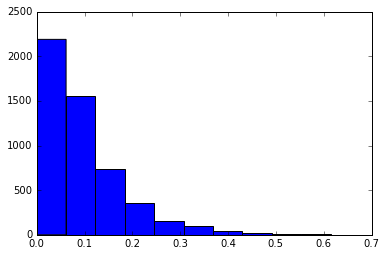

In [39]:
plt.hist(euclidean_distance_matrix[:,11])

(array([  2.68800000e+03,   1.32000000e+03,   6.39000000e+02,
          2.82000000e+02,   1.28000000e+02,   6.80000000e+01,
          2.60000000e+01,   1.20000000e+01,   2.00000000e+00,
          4.00000000e+00]),
 array([ 0.        ,  0.0531333 ,  0.1062666 ,  0.15939989,  0.21253319,
         0.26566649,  0.31879979,  0.37193308,  0.42506638,  0.47819968,
         0.53133298]),
 <a list of 10 Patch objects>)

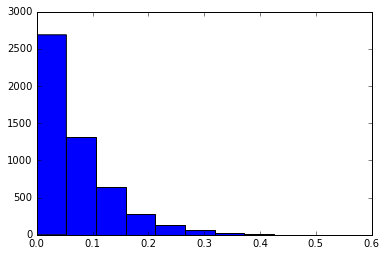

In [40]:
plt.hist(euclidean_distance_matrix[:,12])

(array([ 2335.,  1018.,  1222.,    16.,   435.,    11.,   101.,    15.,
           11.,     5.]),
 array([ 0.01785714,  0.08928571,  0.16071429,  0.23214286,  0.30357143,
         0.375     ,  0.44642857,  0.51785714,  0.58928571,  0.66071429,
         0.73214286]),
 <a list of 10 Patch objects>)

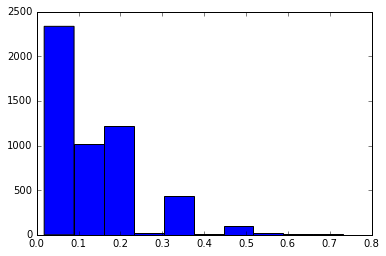

In [41]:
plt.hist(euclidean_distance_matrix[:,13])

(array([ 1132.,  1821.,   523.,   663.,   408.,   128.,   280.,    17.,
          146.,    51.]),
 array([ 0.        ,  0.08571429,  0.17142857,  0.25714286,  0.34285714,
         0.42857143,  0.51428571,  0.6       ,  0.68571429,  0.77142857,
         0.85714286]),
 <a list of 10 Patch objects>)

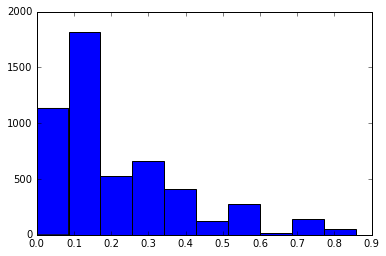

In [42]:
plt.hist(euclidean_distance_matrix[:,14])

(array([ 1826.,   848.,  1351.,   251.,   633.,    45.,   176.,     4.,
           31.,     4.]),
 array([ 0.        ,  0.07321429,  0.14642857,  0.21964286,  0.29285714,
         0.36607143,  0.43928571,  0.5125    ,  0.58571429,  0.65892857,
         0.73214286]),
 <a list of 10 Patch objects>)

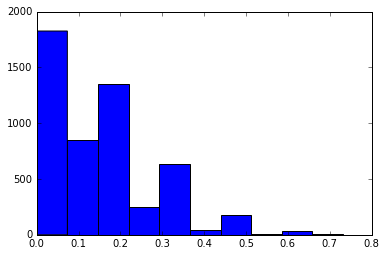

In [43]:
plt.hist(euclidean_distance_matrix[:,15])

(array([ 2939.,   888.,   526.,   235.,   161.,   122.,   122.,    29.,
           74.,    73.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

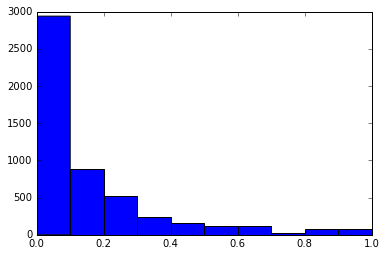

In [44]:
plt.hist(euclidean_distance_matrix[:,16])

(array([ 3843.,   486.,   368.,   144.,   112.,    73.,    65.,     9.,
           35.,    34.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

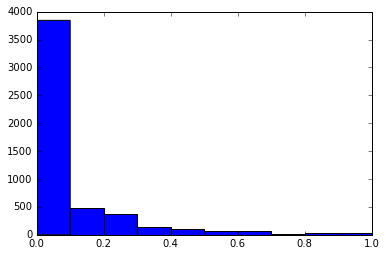

In [45]:
plt.hist(euclidean_distance_matrix[:,17])

(array([  3.26700000e+03,   1.11000000e+03,   4.36000000e+02,
          1.82000000e+02,   8.20000000e+01,   6.20000000e+01,
          1.90000000e+01,   4.00000000e+00,   5.00000000e+00,
          2.00000000e+00]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

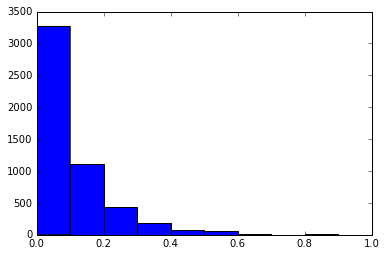

In [46]:
plt.hist(euclidean_distance_matrix[:,18])

## Test con distintos grupos de features

In [30]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#### Todos

In [39]:
selected_features = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin", \
    "start_time","end_time","traveled_days","frequence_regularity","P100_bus_trips"]

In [36]:
len(selected_features)

15

In [53]:
set_features = list(set(powerset(selected_features)))

In [54]:
counter = 0
for a_set in set_features:
    if len(a_set) > 10:
        counter +=1
print counter*18/3600

108.89


In [89]:
counter = 0
index_set = []
rendimientos = []
for a_set in set_features:
    if len(a_set) > 10:
        print "El set: " + str(counter)
        abril_selected_features = filter_features(abril_vectors,a_set)
        septiembre_selected_features = filter_features(septiembre_vectors,a_set)
        a_matrix = compare_vectors_with_shared_matrix(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2)
        n_identified,selected_distance,identified_indexs = get_n_correct(a_matrix,limit)
        porcentaje_correcto = n_identified*100/limit
        print "Rendimiento " + str(round(porcentaje_correcto,2))+ "%"
        index_set.append(counter)
        rendimientos.append(porcentaje_correcto)
        counter += 1

El set: 0
16.1088879108
Rendimiento 44.82%
El set: 1
16.3424680233
Rendimiento 44.77%
El set: 2
15.9571650028
Rendimiento 42.17%
El set: 3
16.6997489929
Rendimiento 42.66%
El set: 4
16.0415539742
Rendimiento 44.26%
El set: 5
16.0938608646
Rendimiento 45.99%
El set: 6
16.0253040791
Rendimiento 45.83%
El set: 7
16.2688810825
Rendimiento 43.64%
El set: 8
16.1731162071
Rendimiento 44.09%
El set: 9
16.2017810345
Rendimiento 42.66%
El set: 10
16.3239810467
Rendimiento 42.83%
El set: 11
16.1284461021
Rendimiento 44.32%
El set: 12
16.2966320515
Rendimiento 43.06%
El set: 13
15.9811940193
Rendimiento 42.41%
El set: 14
16.5690391064
Rendimiento 44.23%
El set: 15
16.2137401104
Rendimiento 44.36%
El set: 16
16.2855930328
Rendimiento 44.75%
El set: 17
16.1898479462
Rendimiento 44.9%
El set: 18
16.1334061623
Rendimiento 43.64%
El set: 19
16.3602621555
Rendimiento 45.1%
El set: 20
16.1411290169
Rendimiento 44.26%
El set: 21
15.9312860966
Rendimiento 42.46%
El set: 22
16.1853749752
Rendimiento 44.42%


In [55]:
set_features[1915]

('msal',
 'kmMaxDist',
 'unc_entropy',
 'random_entropy',
 'start_time',
 'frequence_regularity',
 'p100_exclusive_bus_days',
 'P100_bus_trips')